**Initialization**

In [1]:
import numpy as np

import datetime as dt

%tensorflow_version 2.x
import tensorflow as tf

import matplotlib.pyplot as plt

# **Task 1: Data set**

The Cifar10 dataset comes directly in a two-part dataset for training and test data. The training dataset contains 50000 image-label pairs and the test dataset 10000 image-label pairs. The labels are displayed as numbers from 0 to 9. Among other things in the following code snippet these numbers are mapped to their string label class names. The images in the datasets come up with a fixed shape of 32 x 32 x 3. Thus no resizing is necessary. 

Additionally, some example images of the dataset are displayed with the corresponding string label class name.

170500096/170498071 [==============================] - 6s 0us/step
Training inputs shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Test inputs shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)


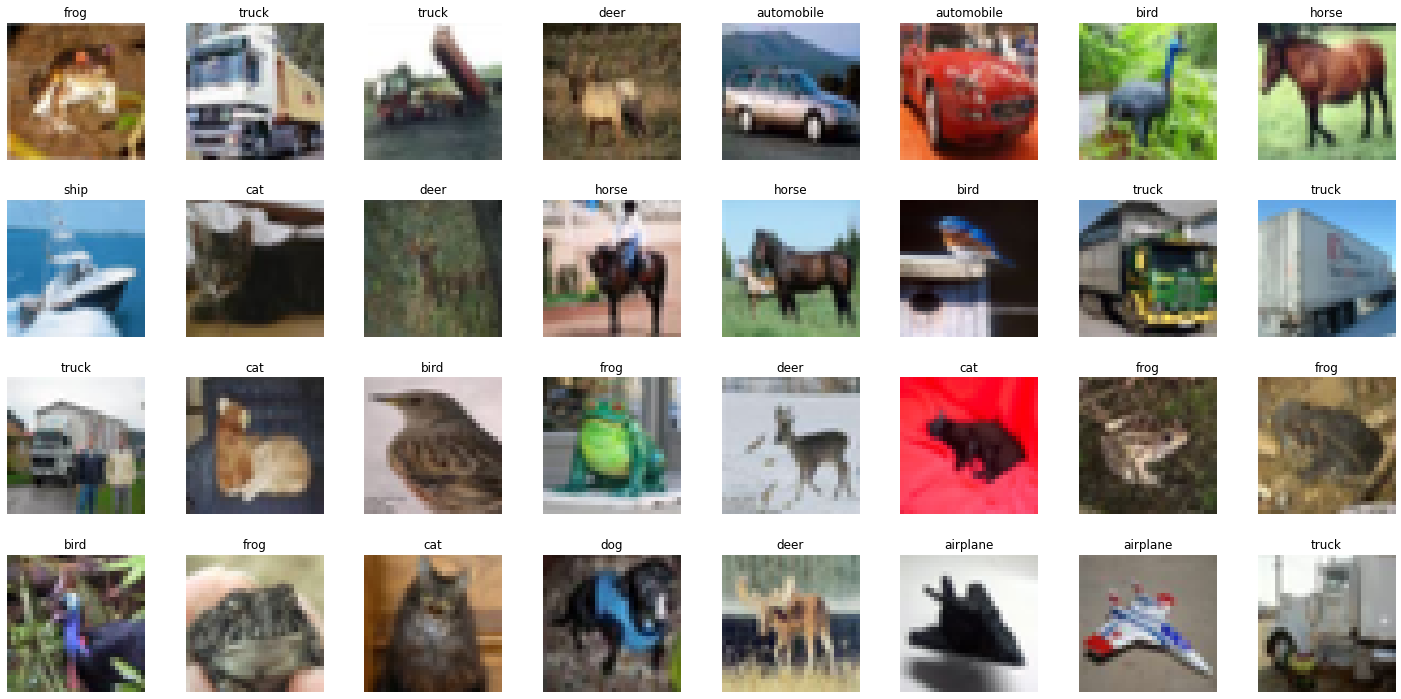

In [2]:
(training_inputs, training_labels), (test_inputs, test_labels) = tf.keras.datasets.cifar10.load_data()

print("Training inputs shape: " + str(training_inputs.shape))
print("Training labels shape: " + str(training_labels.shape))
print("Test inputs shape: " + str(test_inputs.shape))
print("Test labels shape: " + str(test_labels.shape))

label_encoding = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
fig, ax = plt.subplots(4, 8, figsize=(20,10))
fig.tight_layout()
ax = ax.flatten()
for i in range(32):
  image = training_inputs[i]
  label = label_encoding[training_labels[i][-1]]

  ax[i].imshow(image)
  ax[i].set_title(label)
  ax[i].axis("off")

Input pipeline

In [3]:
batch_size = 256

# Creates tensorflow datasets for the training and test data.
training_dataset = tf.data.Dataset.from_tensor_slices((training_inputs, training_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_inputs, test_labels))

# Conducts the normalization of the inputs (images) and the one-hot-encoding of the targets.
training_dataset = training_dataset.map(lambda inp, tar: ((2*(inp/255)-1), tf.one_hot(tf.squeeze(tar), 10)))  # tf.squeeze(tar) to remove dimensions of size 1 from the shape of the target-tensors.
test_dataset = test_dataset.map(lambda inp, tar: ((2*(inp/255)-1), tf.one_hot(tf.squeeze(tar), 10)))     
                                                                                          
# Batches, shuffles and prefetches the training- and test datasets.
training_dataset = training_dataset.batch(batch_size).shuffle(buffer_size = batch_size).prefetch(128)
test_dataset = test_dataset.batch(batch_size).shuffle(buffer_size = batch_size).prefetch(128)

# **Task 2.2: Model - DenseNet**

**Class TransitionLayer**

Implementation of a callable Transition Layer for the DenseNet. 

This one should include:

*   Concolutional Layer
*   Batch Normalization
*   Activation Function ReLu
*   Pooling Layer (AveragePooling)













In [4]:
# Description: The class TransitionLayer describes a transition layer of a DenseNet.
class TransitionLayer(tf.keras.layers.Layer): 
  
  def __init__(self, num_channels_trans_layer):
    super(TransitionLayer, self).__init__()

    self.conv_1 = tf.keras.layers.Conv2D(filters = num_channels_trans_layer,
                                         kernel_size = 1,
                                         activation = None,
                                         padding = 'same',
                                         kernel_initializer = tf.keras.initializers.glorot_normal,   
                                         bias_initializer = 'zeros',                                 
                                         kernel_regularizer = tf.keras.regularizers.L2(0.01))        
    self.batch_norm_1 = tf.keras.layers.BatchNormalization()                                         
    self.activ_1 = tf.keras.activations.relu                         
    self.aver_pool_1 = tf.keras.layers.AveragePooling2D(strides=(2, 2), padding = 'same')   #Without strides?

  # Description: This function conducts one forward-step of the transition layer. 
  #              The python decorator @tf.function is used to bundle multiple computations into one computational graph.
  #              @parameters: (input) x, training (to differ between training and test calls of the residual block)
  #              @returns: (prediction) x
  @tf.function
  def call(self, x, training = True):
    x = self.conv_1(x)
    x = self.batch_norm_1(x, training)
    x = self.activ_1(x)
    x = self.aver_pool_1(x)
    return x

**Class ConvolutionalBlock**

This class is needed to create a Dense Block. It includes one convolutional layer. When calling, the forward step is conducted and the output of the layer is concatenate with the input itself. The result of the concatenation is the output of the convolutional block.

In [5]:
# Description: The class ConvolutionalBlock describes a convolutional block of a DenseBlock.
class ConvolutionalBlock(tf.keras.layers.Layer): 
  
  def __init__(self, num_filter):
    super(ConvolutionalBlock, self).__init__()

    self.batch_norm_1 = tf.keras.layers.BatchNormalization()                                         # (4)
    self.activ_1 = tf.keras.activations.relu                
    self.conv_1 = tf.keras.layers.Conv2D(filters = num_filter,
                                         kernel_size = 1,
                                         activation = None,
                                         padding = 'same',
                                         kernel_initializer = tf.keras.initializers.glorot_normal,   # (1)
                                         bias_initializer = 'zeros',                                 # (2)
                                         kernel_regularizer = tf.keras.regularizers.L2(0.01))        # (3)
    self.conv_2 = tf.keras.layers.Conv2D(filters = num_filter,
                                         kernel_size = 3,
                                         activation = None,
                                         padding = 'same',
                                         kernel_initializer = tf.keras.initializers.glorot_normal,   # (1)
                                         bias_initializer = 'zeros',                                 # (2)
                                         kernel_regularizer = tf.keras.regularizers.L2(0.01))        # (3)
    self.batch_norm_2 = tf.keras.layers.BatchNormalization()                                         # (4)
    self.activ_2 = tf.keras.activations.relu          
    self.concat = tf.keras.layers.Concatenate()               

  # Description: This function conducts one forward-step of the convolutional block. Therefore the block output
  #              is concatenated with the block input. The python decorator @tf.function is used to bundle multiple 
  #              computations into one computational graph.
  #              @parameters: block_input, training (to differ between training and test calls of the residual block)
  #              @returns: block_output
  @tf.function
  def call(self, block_input, training = True):
    x = self.batch_norm_1(block_input, training)
    x = self.activ_1(x)
    x = self.conv_1(x)
    x = self.conv_2(x) 
    x = self.batch_norm_2(x, training)
    x = self.activ_2(x)

    block_output = self.concat([x, block_input]) 
    return block_output

**Class DenseBlock**

Implementation of the Dense Blocks for the DenseNet. They include as many convolutional blocks as the init parameter list_num_filter defines. The total number of convolutional layers of the Dense Block is list_num_filter.

In [6]:
# Description: The class DenseBlock describes a dense block of a DenseNet.
class DenseBlock(tf.keras.layers.Layer): 

  def __init__(self, list_num_filter):
    super(DenseBlock, self).__init__()

    self.convolutional_blocks = []
    for num_filter in list_num_filter:
      self.convolutional_blocks.append(ConvolutionalBlock(num_filter))

  # Description: This function conducts one forward-step of the dense block. 
  #              The python decorator @tf.function is used to bundle multiple computations into one computational graph.
  #              @parameters: (input) x, training (to differ between training and test calls of the residual block)
  #              @returns: (output) x
  @tf.function
  def call(self, x, training = True):
    for conv_block in self.convolutional_blocks:
      x = conv_block(x, training)
    return x

**Class DenseNet**

In [7]:
# The class DenseNet describes a dense convolutional neural network with a feature extractor and a classifier.
class DenseNet(tf.keras.Model): 
  
  def __init__(self, num_dense_blocks, list_num_filter, growth_rate):
    super(DenseNet, self).__init__()
    num_conv_blocks = len(list_num_filter)
    # Feature extractor
    self.conv_1 = tf.keras.layers.Conv2D(filters = 32,
                                         kernel_size = 3,
                                         activation = None,
                                         padding = 'same',
                                         kernel_initializer = tf.keras.initializers.glorot_normal,   # (1)
                                         bias_initializer = 'zeros',                                 # (2)
                                         kernel_regularizer = tf.keras.regularizers.L2(0.01),        # (3)
                                         input_shape = (32, 32, 3))
    self.batch_norm_1 = tf.keras.layers.BatchNormalization()                                         # (4)
    self.activ_1 = tf.keras.activations.relu   

    num_channels_trans_layer = growth_rate * num_conv_blocks
    self.dense_blocks_and_trans_layers = []
    for _ in range(num_dense_blocks - 1):                         # The last dense block does not need a transition layer -> num_dense_blocks - 1 
      self.dense_blocks_and_trans_layers.append(DenseBlock(list_num_filter))   
      self.dense_blocks_and_trans_layers.append(TransitionLayer(num_channels_trans_layer)) 
    self.last_dense_block = DenseBlock(list_num_filter)

    # Classifier
    self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
    self.dropout = tf.keras.layers.Dropout(rate = 0.5)                                               # (5)    
    self.output_layer = tf.keras.layers.Dense(10, 
                                              activation=tf.keras.activations.softmax)#,
                                              #kernel_initializer = tf.keras.initializers.glorot_normal,   
                                              #bias_initializer = 'zeros',                                 
                                              #kernel_regularizer = tf.keras.regularizers.L2(0.01))

  # Description: This function conducts one forward-step of the Dense CNN. 
  #              The python decorator @tf.function is used to bundle multiple computations into one computational graph.
  #              @parameters: (input) x, training (to differ between training and test calls of the residual block)
  #              @returns: (prediction) x
  @tf.function
  def call(self, x, training = True):
    x = self.conv_1(x)
    x = self.batch_norm_1(x, training)
    x = self.activ_1(x)

    for i in self.dense_blocks_and_trans_layers:
      x = i(x, training)
    x = self.last_dense_block(x, training)

    x = self.global_pool(x)
    x = self.dropout(x, training)
    x = self.output_layer(x)
    return x

# **Task 3: Training and Analysis**

In [8]:
# Description: This function conducts a forward-step and the backpropagation of a CNN. It does not matter whether the CNN is a ResNet or 
#              a DenseNet (this is defined by the parameter model). Additionally, the average training loss and accuracy is determined.
#              @parameters: model, training_data, loss_fn, optimizer, training (to differ between training and test calls of the CNN)
#              @returns: training_loss, training_accuracy
#@tf.function
def training_step(model, training_data, loss_fn, optimizer, training = True):
  training_losses = []
  training_accuracies = []

  for (input, target) in training_data:
    with tf.GradientTape() as tape:
      prediction = model(input, training)
      current_training_loss = loss_fn(target, prediction)+ tf.math.reduce_sum(model.losses)   # (3)
      gradients = tape.gradient(current_training_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    training_losses.append(current_training_loss.numpy())

    current_training_accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    training_accuracies.append(np.mean(current_training_accuracy))  
  
  training_loss = np.mean(training_losses)
  training_accuracy = np.mean(training_accuracies)
  return training_loss, training_accuracy


# Description: This function determines the average test loss and accuracy of a CNN. It does not matter 
#              whether the CNN is a ResNet or a DenseNet (this is defined by the parameter model).
#              @parameters: model, test_data, loss_fn, training (to differ between training and test calls of the CNN)
#              @returns: test_loss, test_accuracy
#@tf.function
def test(model, test_data, loss_fn, training = False):
  test_losses = []
  test_accuracies = []

  for (input, target) in test_data:
    prediction = model(input, training)
    
    current_test_loss = loss_fn(target, prediction)
    test_losses.append(current_test_loss.numpy())

    current_test_accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    test_accuracies.append(np.mean(current_test_accuracy))   
    
  test_loss = np.mean(test_losses)
  test_accuracy = np.mean(test_accuracies)
  return test_loss, test_accuracy

Epoch 0
2020-12-08 15:19:23.611276
Training accuracy: 0.24245455994897958
Test accuracy: 0.13388671875
Epoch 1
2020-12-08 15:20:35.197184
Training accuracy: 0.4031130420918367
Test accuracy: 0.104296875
Epoch 2
2020-12-08 15:21:19.652806
Training accuracy: 0.5139429209183674
Test accuracy: 0.135546875
Epoch 3
2020-12-08 15:22:04.266857
Training accuracy: 0.6006935586734694
Test accuracy: 0.20810546875
Epoch 4
2020-12-08 15:22:49.597514
Training accuracy: 0.6566366390306123
Test accuracy: 0.26240234375
Epoch 5
2020-12-08 15:23:34.957790
Training accuracy: 0.690186543367347
Test accuracy: 0.44541015625
Epoch 6
2020-12-08 15:24:20.143503
Training accuracy: 0.7163464604591837
Test accuracy: 0.48212890625
Epoch 7
2020-12-08 15:25:05.824533
Training accuracy: 0.7370376275510204
Test accuracy: 0.5916015625
Model: "dense_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple 

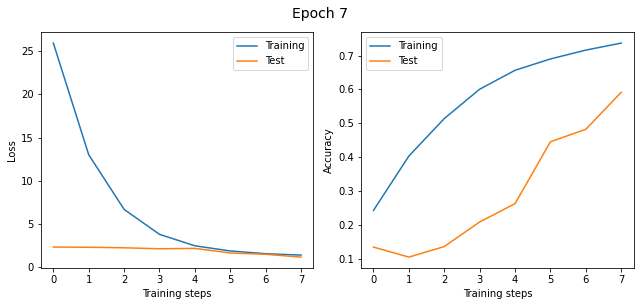

Epoch 8
2020-12-08 15:25:51.677380
Training accuracy: 0.7502072704081633
Test accuracy: 0.44814453125
Epoch 9
2020-12-08 15:26:37.114910
Training accuracy: 0.758286830357143
Test accuracy: 0.50400390625
Epoch 10
2020-12-08 15:27:22.219152
Training accuracy: 0.7724968112244899
Test accuracy: 0.475390625
Epoch 11
2020-12-08 15:28:07.477327
Training accuracy: 0.7732940051020408
Test accuracy: 0.61318359375
Model: "dense_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  896       
_________________________________________________________________
batch_normalization (BatchNo multiple                  128       
_________________________________________________________________
dense_block (DenseBlock)     multiple                  15824     
_________________________________________________________________
transition_layer (Transition multiple         

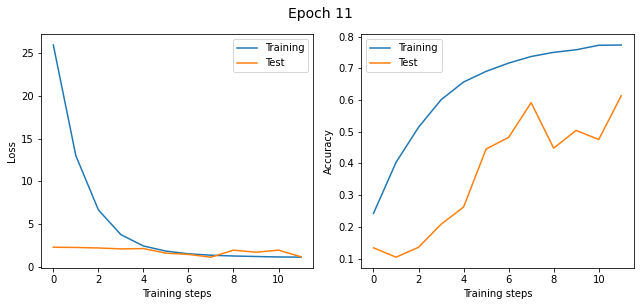

Epoch 12
2020-12-08 15:28:53.004103
Training accuracy: 0.7845424107142857
Test accuracy: 0.6662109375
Model: "dense_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  896       
_________________________________________________________________
batch_normalization (BatchNo multiple                  128       
_________________________________________________________________
dense_block (DenseBlock)     multiple                  15824     
_________________________________________________________________
transition_layer (Transition multiple                  11160     
_________________________________________________________________
dense_block_1 (DenseBlock)   multiple                  21808     
_________________________________________________________________
transition_layer_1 (Transiti multiple                  21720     
_____________________

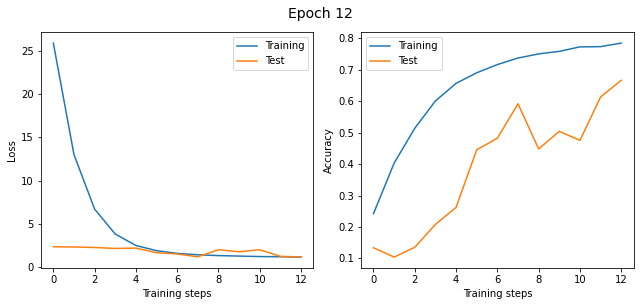

Epoch 13
2020-12-08 15:29:38.715038
Training accuracy: 0.7853475765306123
Test accuracy: 0.64794921875
Epoch 14
2020-12-08 15:30:24.196056
Training accuracy: 0.7954878826530613
Test accuracy: 0.58046875
Epoch 15
2020-12-08 15:31:09.282153
Training accuracy: 0.7991191007653061
Test accuracy: 0.61337890625
Epoch 16
2020-12-08 15:31:54.438890
Training accuracy: 0.8068239795918367
Test accuracy: 0.555078125
Epoch 17
2020-12-08 15:32:39.743930
Training accuracy: 0.8087810905612245
Test accuracy: 0.62734375
Epoch 18
2020-12-08 15:33:25.196800
Training accuracy: 0.8083027742346939
Test accuracy: 0.7158203125
Model: "dense_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  896       
_________________________________________________________________
batch_normalization (BatchNo multiple                  128       
__________________________________________

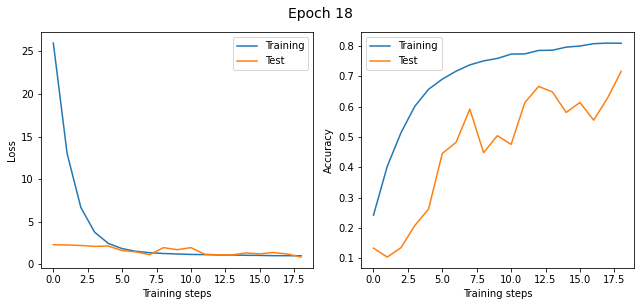

Epoch 19
2020-12-08 15:34:10.867859
Training accuracy: 0.8156090561224489
Test accuracy: 0.66103515625
Epoch 20
2020-12-08 15:34:56.248518
Training accuracy: 0.814389349489796
Test accuracy: 0.45517578125
Epoch 21
2020-12-08 15:35:41.979511
Training accuracy: 0.8189732142857143
Test accuracy: 0.52529296875
Epoch 22
2020-12-08 15:36:27.347179
Training accuracy: 0.8224728954081633
Test accuracy: 0.611328125
Epoch 23
2020-12-08 15:37:12.710617
Training accuracy: 0.8229432397959183
Test accuracy: 0.58046875
Epoch 24
2020-12-08 15:37:57.907774
Training accuracy: 0.8232382015306123
Test accuracy: 0.61796875
Epoch 25
2020-12-08 15:38:43.338304
Training accuracy: 0.8300581951530612
Test accuracy: 0.66533203125
Epoch 26
2020-12-08 15:39:28.526796
Training accuracy: 0.8309231505102042
Test accuracy: 0.67724609375
Epoch 27
2020-12-08 15:40:13.782137
Training accuracy: 0.8295918367346938
Test accuracy: 0.66962890625
Epoch 28
2020-12-08 15:40:59.498051
Training accuracy: 0.830939094387755
Test accu

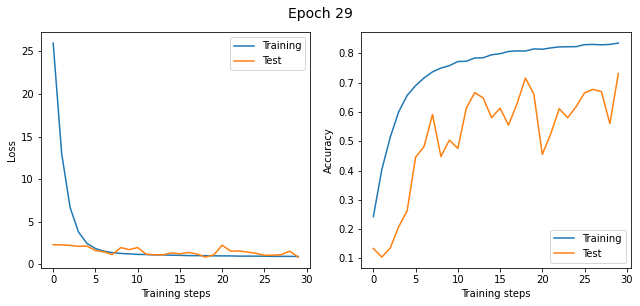

Epoch 30
2020-12-08 15:42:30.795152
Training accuracy: 0.837531887755102
Test accuracy: 0.690234375
Epoch 31
2020-12-08 15:43:16.474998
Training accuracy: 0.8378946109693877
Test accuracy: 0.7265625
Epoch 32
2020-12-08 15:44:01.974339
Training accuracy: 0.8409996811224489
Test accuracy: 0.62685546875
Epoch 33
2020-12-08 15:44:47.328726
Training accuracy: 0.842398756377551
Test accuracy: 0.68525390625
Epoch 34
2020-12-08 15:45:32.975317
Training accuracy: 0.8431999362244899
Test accuracy: 0.69541015625
Epoch 35
2020-12-08 15:46:18.349733
Training accuracy: 0.8430046237244898
Test accuracy: 0.75869140625
Model: "dense_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  896       
_________________________________________________________________
batch_normalization (BatchNo multiple                  128       
_________________________________________

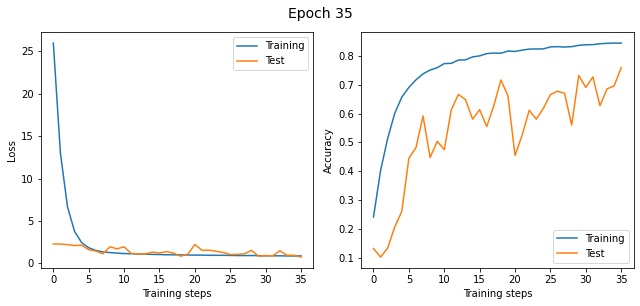

Epoch 36
2020-12-08 15:47:04.185685
Training accuracy: 0.8470862563775511
Test accuracy: 0.692578125
Epoch 37
2020-12-08 15:47:49.538757
Training accuracy: 0.8459024234693877
Test accuracy: 0.71025390625
Epoch 38
2020-12-08 15:48:35.091462
Training accuracy: 0.8490911989795918
Test accuracy: 0.77236328125
Epoch 39
2020-12-08 15:49:20.590454
Training accuracy: 0.8506058673469388
Test accuracy: 0.50498046875
Epoch 40
2020-12-08 15:50:05.999390
Training accuracy: 0.8475446428571429
Test accuracy: 0.7142578125
Epoch 41
2020-12-08 15:50:51.859262
Training accuracy: 0.8536232461734694
Test accuracy: 0.70126953125
Epoch 42
2020-12-08 15:51:37.346947
Training accuracy: 0.8514269770408163
Test accuracy: 0.7201171875
Epoch 43
2020-12-08 15:52:22.992346
Training accuracy: 0.8526945153061225
Test accuracy: 0.67509765625
Epoch 44
2020-12-08 15:53:08.572645
Training accuracy: 0.8505620216836736
Test accuracy: 0.69384765625
Epoch 45
2020-12-08 15:53:54.491026
Training accuracy: 0.854719387755102
Test

In [9]:
# Description: This part creates objects of a ResNet and DenseNet and executes the training and testing of these models in the training and test loop. The training 
#              takes place over an amount of epochs (n_epochs) with a predefined learning rate. The loss function defines the kind of loss-calculation. The optimizer 
#              is needed to adjust the gradients in the training steps. Moreover, the data for the visualization of the training and test progress is collected.
#              In order to better monitor the training progress, the loss and accuracy graphs are provided in addtion to the numerical outputs when the test accuracy 
#              has significantly improved.
tf.keras.backend.clear_session()

num_dense_blocks = 12
list_num_filter =[32, 16, 8]
num_conv_blocks = len(list_num_filter)
growth_rate = 40
model = DenseNet(num_dense_blocks, list_num_filter, growth_rate)   

n_epochs = 50
learning_rate = 0.001
loss_fn = tf.keras.losses.CategoricalCrossentropy()                    # CategoricalCrossentropy because of 10 labels to differ.
optimizer = tf.keras.optimizers.Adam(learning_rate, amsgrad = True)    # Optimizer Adam (Adaptive Moment Estimation) with AMSGrad activated.

training_losses = []
training_accuracies = []
test_losses = []
test_accuracies = []

dynamic_threshold_train_visio = 0.5                                    # Test accuracy threshold from which the training progress is displayed.
# Training and test loop
for epoch in range(n_epochs):
    print('Epoch ' + str(epoch))
    ts_now = dt.datetime.now()
    print(ts_now)

    training_loss, training_accuracy = training_step(model, training_dataset, loss_fn, optimizer, training = True)
    training_losses.append(training_loss)
    training_accuracies.append(training_accuracy)

    test_loss, test_accuracy = test(model, test_dataset, loss_fn, training = False)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print("Training accuracy: " + str(training_accuracy))
    print("Test accuracy: " + str(test_accuracy))

    # Visualization during training to check how the CNN is doing. In 5% steps of the test accuracy starting up from 50% test accuracy.
    if test_accuracy >= dynamic_threshold_train_visio: 
      model.summary()  #!!!find a different place for this!!!

      fig, ax = plt.subplots(1,2, figsize=(9, 4))

      fig.suptitle(('Epoch ' + str(epoch)), fontsize=14, y=1.05)
      line1, = ax[0].plot(training_losses)
      line2, = ax[0].plot(test_losses)
      ax[0].set_xlabel("Training steps")
      ax[0].set_ylabel("Loss")
      ax[0].legend((line1, line2),("Training", "Test"))

      line1, = ax[1].plot(training_accuracies)
      line2, = ax[1].plot(test_accuracies)
      ax[1].set_xlabel("Training steps")
      ax[1].set_ylabel("Accuracy")
      ax[1].legend((line1, line2),("Training", "Test"))

      fig.tight_layout()
      plt.draw()
      plt.show()

      # Increases the test accuracy threshold by 5%.  
      dynamic_threshold_train_visio += 0.05

# **Visualization**

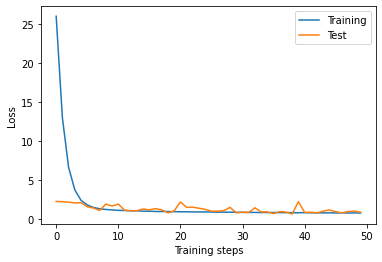

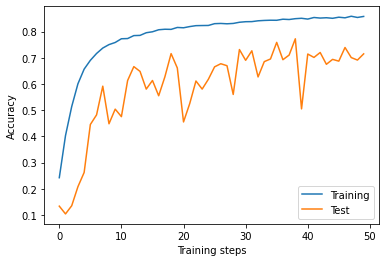

In [10]:
# Description: Figure 1 shows the loss for each epoch during the training and testing of the model.
#              Figure 2 shows the accuracy for each epoch during the training and testing of the model.
plt.figure()
line1, = plt.plot(training_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1, line2),("Training", "Test"))
plt.show()

plt.figure()
line1, = plt.plot(training_accuracies)
line2, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.legend((line1, line2),("Training", "Test"))
plt.show()